# Notebooks Analysis

## Introduction

We want to know what affects the price of the notebooks in Chile. We make an analysis of the different characteristics and the available information when one wants to buy a notebook.

The data was scrapped from the [solotodo website](https://www.solotodo.cl/notebooks).

In [1]:
import numpy as np
np.random.seed(12345)
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
print(f"Numpy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Matplotlib version: {matplotlib.__version__}")
print(f"Seaborn version: {sns.__version__}")

Numpy version: 1.19.5
Pandas version: 1.1.5
Matplotlib version: 3.2.2
Seaborn version: 0.11.2


## Import Dataset

Upload the dataset to google colab

In [2]:
from google.colab import files
import io
uploaded = files.upload()
dataset = pd.read_csv(io.BytesIO(uploaded["notebooks.csv"]))

Saving notebooks.csv to notebooks.csv


The dataset has the following information.

In [3]:
print(f"Info: {dataset.info()}")
print(f"\nShape: {dataset.shape}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1163 entries, 0 to 1162
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   dedicated_video_card  281 non-null    object
 1   name                  1163 non-null   object
 2   price                 1163 non-null   int64 
 3   processor             1163 non-null   object
 4   ram                   1163 non-null   object
 5   screen                1163 non-null   object
 6   storage               1163 non-null   object
 7   video_card            1161 non-null   object
dtypes: int64(1), object(7)
memory usage: 72.8+ KB
Info: None

Shape: (1163, 8)


Drop the row containing the missing value in the `video_card` column.

In [4]:
dataset.drop(index=dataset[dataset["video_card"].isna()].index, inplace=True)

Reserve $160$ rows of the data to validate the final model. **Skip the analysis on the validation dataset**, to prevent possible bias.

In [5]:
dataset = dataset.sample(frac=1, random_state=362)
dataset.reset_index(drop=True, inplace=True)
df = dataset.iloc[0:1000]
validation_df = dataset.iloc[1000:]

Verify if the data has duplicated rows. And drop them.

In [6]:
duplicates_num = sum(df.duplicated())
print(f"Number of duplicated rows: {duplicates_num}")
df = df.copy()
#df.drop_duplicates(inplace=True, ignore_index=True)
print(f"The resulting Training set shape: {df.shape}")
print(f"The Validation set shape: {validation_df.shape}")

Number of duplicated rows: 0
The resulting Training set shape: (1000, 8)
The Validation set shape: (161, 8)


## Exploratory Data Analysis

The dataset looks like.

In [7]:
df.head(10)

,dedicated_video_card,name,price,processor,ram,screen,storage,video_card
0,NaN,Lenovo ThinkPad X240 [20AMS2LR00],300000,Intel Core i5-4200U (2 núcleos / 4 hilos / 160...,4 GB DDR3L (1600 MHz),"LED 12.5"" (1366x768) / 60 Hz",HDD 500GB (5400rpm),Intel HD Graphics 4400 (Integrada)
1,NaN,Dell Vostro 5402 (i5-1135G7 / 8GB / 256GB SSD ...,625000,Intel Core i5-1135G7 (4 núcleos / 8 hilos / 24...,8 GB DDR4 (3200 MHz),"LED 14.0"" (1920x1080) / 60 Hz",SSD 256GB,Intel Iris Xe Graphics G7 80EUs (Integrada)
2,NaN,Acer Aspire 3 A314-22-R522-1 [NX.HVWAL.00Z.1],599990,AMD Athlon Silver 3050U (2 núcleos / 2 hilos /...,12 GB DDR4 (2400 MHz),"LED 14.0"" (1920x1080) / 60 Hz",SSD 256GB,AMD Radeon RX Vega 2 (Integrada)
3,NVIDIA GeForce MX350 (2 GB),ASUS Zenbook 14 Q407IQ-BR5N4,679000,AMD Ryzen 5 4500U (6 núcleos / 6 hilos / 2300 ...,8 GB LPDDR4X (4266 MHz),"LED 14.0"" (1920x1080) / 60 Hz",SSD 256GB,AMD Radeon RX Vega 6 (Ryzen 4000) (Integrada)
4,NaN,HP 15-EF1018LA [310J2LA],519990,AMD Ryzen 5 4500U (6 núcleos / 6 hilos / 2300 ...,8 GB DDR4 (2666 MHz),"LED 15.6"" (1366x768) / 60 Hz",SSD 256GB,AMD Radeon RX Vega 6 (Ryzen 4000) (Integrada)
5,NaN,HP 240 G8 (i3-1005G1 / 4GB / 1TB / FreeDOS),599990,Intel Core i3-1005G1 (2 núcleos / 4 hilos / 12...,4 GB DDR4 (2666 MHz),"LED 14.0"" (1366x768) / 60 Hz",HDD 1TB (5400rpm),Intel UHD Graphics G1 (Integrada)
6,NaN,Dell Inspiron 14 7000 [i7490-7842SLV-PUS],680000,Intel Core i7-10510U (4 núcleos / 8 hilos / 18...,8 GB LPDDR3 (2133 MHz),"LED 14.0"" (1920x1080) / 60 Hz",SSD 512GB,Intel UHD Graphics 620 (Integrada)
7,NaN,HP 348 G7 (i3-10110U / 4GB / 1TB / W10H),283990,Intel Core i3-10110U (2 núcleos / 4 hilos / 21...,4 GB DDR4 (2666 MHz),"LED 14.0"" (1366x768) / 60 Hz",HDD 1TB (5400rpm),Intel UHD Graphics 630 (Integrada)
8,NaN,Lenovo IdeaPad S145-14API [81UV00AQGJ],299990,AMD Athlon 3020e (2 núcleos / 2 hilos / 1200 M...,4 GB DDR4 (2400 MHz),"LED 14.0"" (1366x768) / 60 Hz",HDD 500GB (5400rpm),AMD Radeon RX Vega 3 (Integrada)
9,NaN,Gateway GWTN156-5BK (8 GB RAM),494000,AMD Ryzen 5 3450U (4 núcleos / 8 hilos / 2100 ...,8 GB DDR4 (2666 MHz),"LED 15.6"" (1920x1080) / 60 Hz",SSD 256GB,AMD Radeon RX Vega 8 (Integrada)


### Price

The basic statistics of the `price` columns are:

In [8]:
df["price"].describe()

count    1.000000e+03
mean     8.630736e+05
std      6.051099e+05
min      9.999000e+04
25%      4.507425e+05
50%      6.999900e+05
75%      1.071740e+06
max      4.599990e+06
Name: price, dtype: float64

Plot the Histogram and Q-Q plots.

In [9]:
import scipy
print(f"Scipy version: {scipy.__version__}")
from scipy import stats

Scipy version: 1.4.1


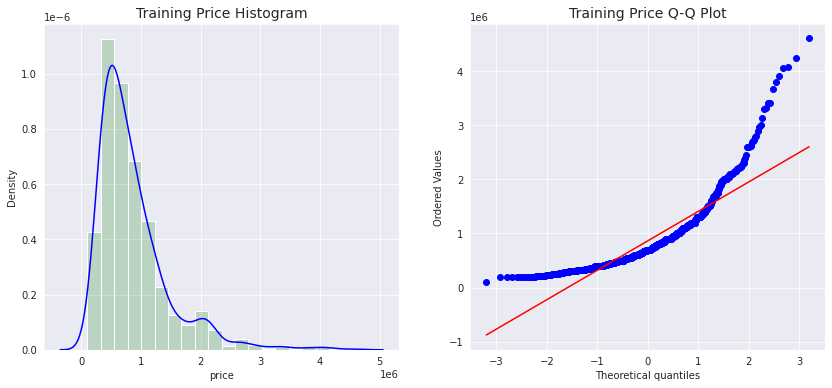

In [10]:
import scipy.stats as stats
fig, axes = plt.subplots(ncols=2, figsize=(14, 6))
sns.histplot(df["price"], alpha=0.2, bins=20, stat="density", color="green", ax=axes[0])
sns.kdeplot(df["price"], color="blue", ax=axes[0])
stats.probplot(df["price"], plot=axes[1])
axes[0].set_title("Training Price Histogram", fontsize=14)
axes[1].set_title("Training Price Q-Q Plot", fontsize=14)
plt.show()

We see that the **`price` column is right-skewed**.

### Brand

Create a new column named `notebook_brand`, with the brand name of each notebook.

In [11]:
nb_brands = ["Acer", "Apple", "ASUS", "BMAX", "CHUWI", 
             "Dell", "EVOO", "Gateway", "Gear", "Gigabyte", 
             "Honor", "HP", "Huawei", "Hyundai", "Lenovo", 
             "Microsoft", "MSI", "Razer", "Samsung", "Toshiba", 
             "V2", "XPG"]
def get_notebook_brand(string):
    for brand in nb_brands:
        if brand in string:
            return brand
df.loc[:, "notebook_brand"] = df["name"].apply(lambda x: get_notebook_brand(x)).astype(str)

Plot the Brand vs Price.

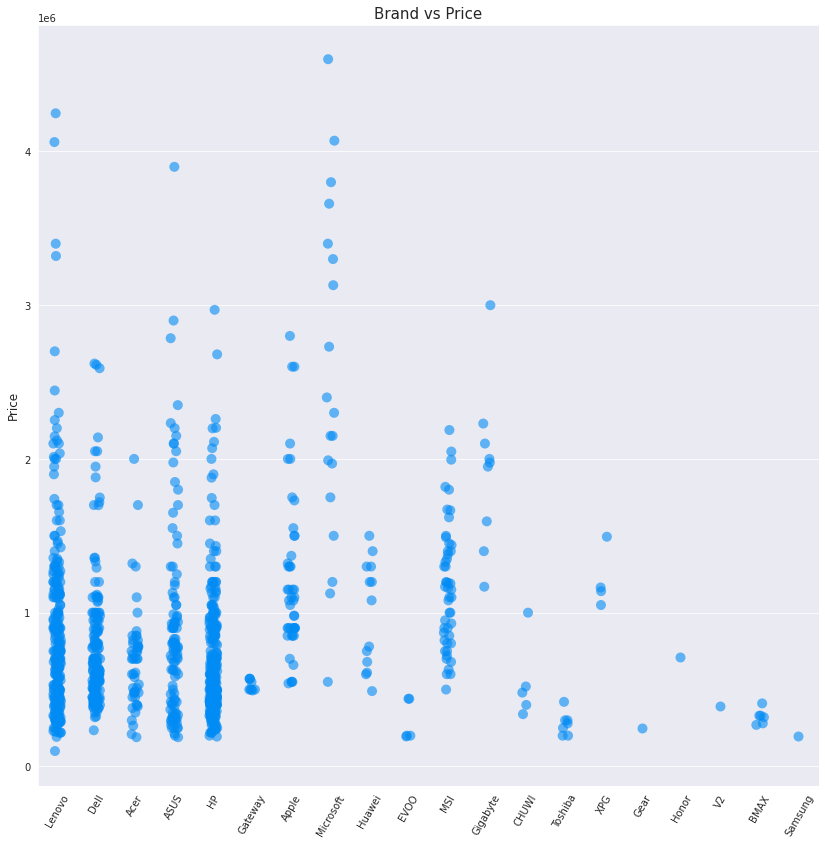

In [12]:
fig, ax = plt.subplots(figsize=(14, 14))
color = ["#018BF5"]
sns.stripplot(data=df, x="notebook_brand", y="price", alpha=0.6, linewidth=0, ax=ax, size=10, dodge=True, jitter=0.1, palette=color)
ax.set_xlabel("", fontsize=12)
ax.set_ylabel("Price", fontsize=12)
ax.set_title("Brand vs Price", fontsize=15)
plt.xticks(rotation=60)
plt.show()

**Notebook brands are concentrated in Asus, Lenovo, HP and Dell**.

### Screen

Create the following new columns: 
* `screen_in`: the screen size measured in inches.
* `screen_resolution`: the resolution of each screen.
* `screen_touch`: whether it is touch or not. 
* `screen_hz`: the hertz of the screen.

In [13]:
import re
df["screen_in"] = df["screen"].apply(lambda x: x[0:6])
df["screen_resolution"] = df["screen"].apply(lambda x: re.findall(r"[0-9]*x[0-9]*", x)[0])
df["screen_touch"] = df["screen"].apply(lambda x: "yes" if any(item in x for item in ["táctil", "tactil"]) else "no")
# Note that the screen_hz column is defined as categorical just for the next plots.
# Later on, we are going to transform each category into numerical.
df["screen_hz"] = df["screen"].apply(lambda x: re.findall(r"[0-9]* Hz", x)[0])

Plot Screen characteristics vs Price.

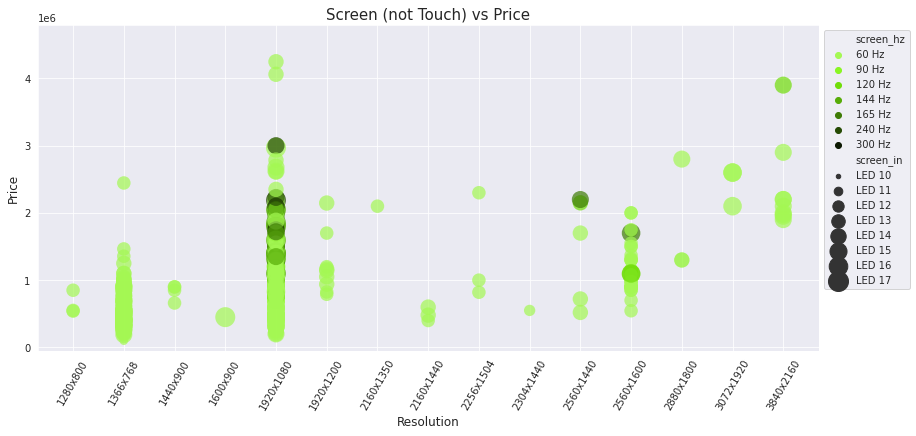

In [14]:
fig, ax = plt.subplots(figsize=(14, 6))
sizes = sorted(df["screen_in"].unique())
hues = ["60 Hz", "90 Hz", "120 Hz", "144 Hz", "165 Hz", "240 Hz", "300 Hz"]
color_list = ["#a4f853", "#89f622", "#70dd09", "#57ac07", "#3e7b05", "#254a03", "#0c1901"]
sns.scatterplot(data=df[df["screen_touch"] == "no"].sort_values("screen_resolution"), x="screen_resolution", y="price", hue="screen_hz", size="screen_in", alpha=0.7, sizes=(400, 20), linewidth=0, ax=ax, size_order=sizes, hue_order=hues, palette=color_list)
ax.set_xlabel("Resolution", fontsize=12)
ax.set_ylabel("Price", fontsize=12)
ax.set_title("Screen (not Touch) vs Price", fontsize=15)
ax.set_ylim([-50000, 4800000])
plt.legend(bbox_to_anchor=(1, 1), loc=0)
plt.xticks(rotation=60)
plt.show()

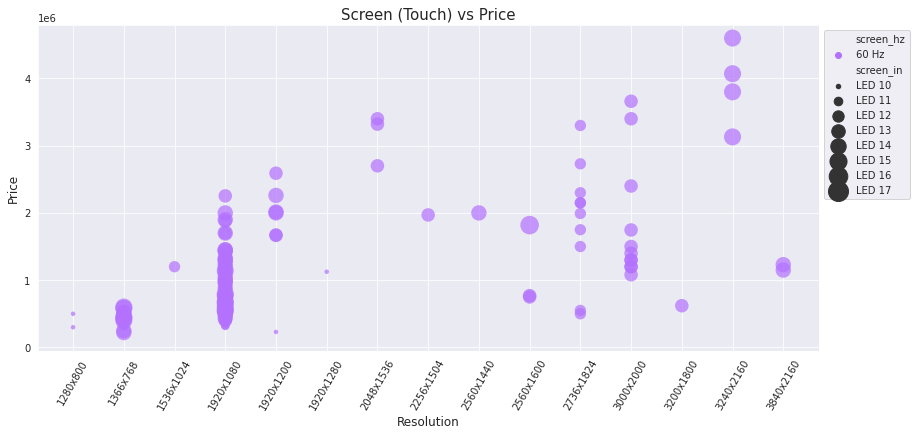

In [15]:
fig, ax = plt.subplots(figsize=(14, 6))
sizes = sorted(df["screen_in"].unique())

sns.scatterplot(data=df[df["screen_touch"] == "yes"].sort_values("screen_resolution"), 
                x="screen_resolution", y="price", hue="screen_hz", size="screen_in", 
                alpha=0.7, sizes=(400, 20), linewidth=0, ax=ax, size_order=sizes, 
                palette=["#b371ff"])
ax.set_xlabel("Resolution", fontsize=12)
ax.set_ylabel("Price", fontsize=12)
ax.set_title("Screen (Touch) vs Price", fontsize=15)
ax.set_ylim([-50000, 4800000])
plt.legend(bbox_to_anchor=(1, 1), loc=0)
plt.xticks(rotation=60)
plt.show()

Wee see that **an slightly increasing line can be adjusted to each of the plots**.

### Processor

Create the following new columns: 
* `processor_brand`: the brand of the processor.
* `processor_cores`: the number of cores of the processor.
* `processor_mhz`: the mega-hertz (million cycles per second) of each processor.


In [16]:
df["processor_brand"] = ""
for idx, item in enumerate(df["processor"]):
    if "Intel" in str(item):
        df.at[idx, "processor_brand"] = "Intel"
    if "AMD" in str(item):
        df.at[idx, "processor_brand"] = "AMD"
    if "Apple" in str(item):
        df.at[idx, "processor_brand"] = "Apple"
    if "Mediatek" in str(item):
        df.at[idx, "processor_brand"] = "Mediatek"
# Note that the screen_hz column is defined as categorical just for the next plots.
# Later on, we are going to transform each category into numerical.
df["processor_cores"] = df["processor"].apply(lambda x: int(re.findall(r"[0-9]*[0-9]", re.findall(r"[0-9]* núcleos", x)[0])[0]))
def get_processor_mhz(string):
    acc = 0
    values = re.findall(r"[0-9]* MHz", string)
    for value in values:
        acc += int(re.findall(r"[0-9]*", value)[0])
    acc = acc / len(values)
    return acc
df["processor_mhz"] = df["processor"].apply(lambda x: get_processor_mhz(x))

Plot the Processor Brand vs Price.

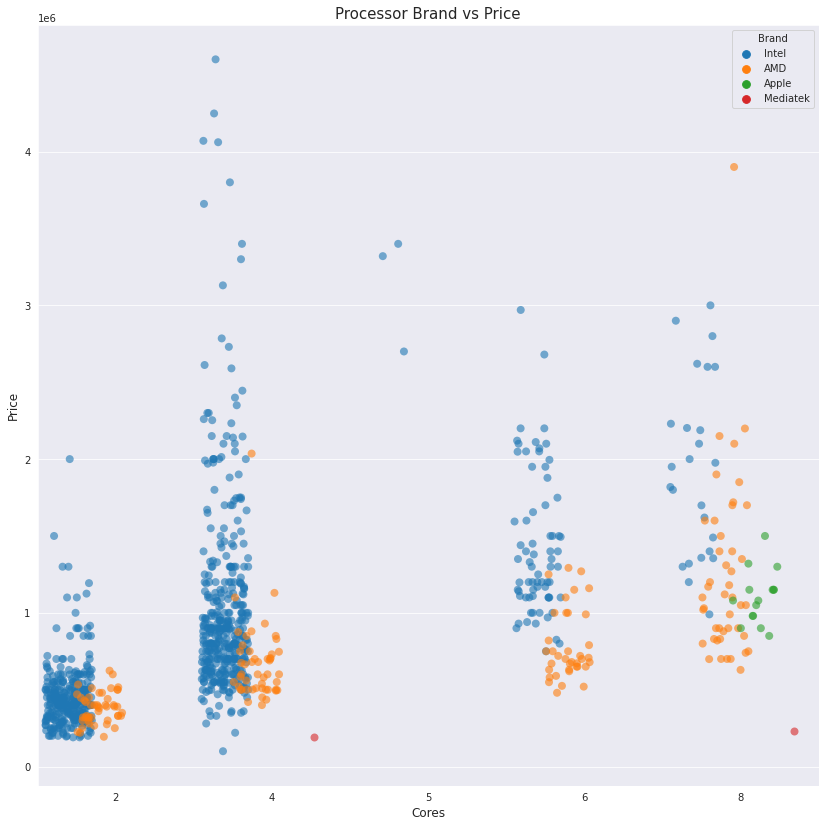

In [17]:
fig, ax = plt.subplots(figsize=(14, 14))
sns.stripplot(data=df, x="processor_cores", y="price", alpha=0.6, linewidth=0, ax=ax, hue="processor_brand", size=8, jitter=0.6, dodge=True)
ax.set_xlabel("Cores", fontsize=12)
ax.set_ylabel("Price", fontsize=12)
ax.set_title("Processor Brand vs Price", fontsize=15)
plt.legend(title="Brand")
plt.show()

**There is an evident correlation between `processor_cores` and `price`**.

Plot the Processor frecuency vs Price

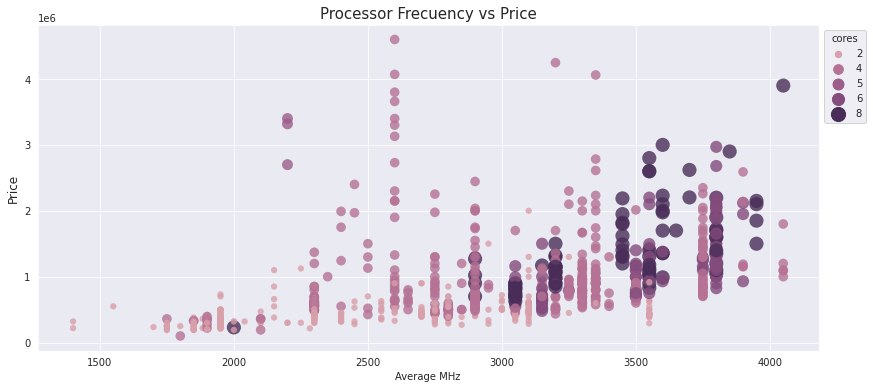

In [18]:
fig, ax = plt.subplots(figsize=(14, 6))
sns.scatterplot(data=df.sort_values("processor_mhz"), x="processor_mhz", y="price", 
                size="processor_cores", hue="processor_cores", alpha=0.8, linewidth=0, 
                ax=ax, sizes=(40, 200), hue_norm=(0, 9))
ax.set_xlabel("Average MHz")
ax.set_ylabel("Price", fontsize=12)
ax.set_title("Processor Frecuency vs Price", fontsize=15)
plt.legend(title="cores", bbox_to_anchor=(1, 1), loc=0)
plt.show()

We see a not so meaningful **exponential relation between `average_mhz` and `price`**.

### Storage

Create the following new columns: 
* `storage_type`: the type.
* `storage_size`: the size in GB.


In [19]:
df["storage_type"] = ""
for idx, item in enumerate(df["storage"]):
    if "HDD" in str(item):
        df.at[idx, "storage_type"] = "HDD"
    if "SSD" in str(item):
        df.at[idx, "storage_type"] = "SSD"
    if "Optane" in str(item):
        df.at[idx, "storage_type"] = "Optane"
    if "eMMC" in str(item):
        df.at[idx, "storage_type"] = "eMMC"
df["storage_size"] = ""
for idx, item in enumerate(df["storage"]):
    if "16GB" in str(item):
        df.at[idx, "storage_size"] = "16GB"
    if "32GB" in str(item):
        df.at[idx, "storage_size"] = "32GB"
    if "64GB" in str(item):
        df.at[idx, "storage_size"] = "64GB"
    if "128GB" in str(item):
        df.at[idx, "storage_size"] = "128GB"
    if "250GB" in str(item):
        df.at[idx, "storage_size"] = "250GB"
    if "240GB" in str(item):
        df.at[idx, "storage_size"] = "250GB"
    if "256GB" in str(item):
        df.at[idx, "storage_size"] = "250GB"
    if "480GB" in str(item):
        df.at[idx, "storage_size"] = "500GB"
    if "512GB" in str(item):
        df.at[idx, "storage_size"] = "500GB"
    if "500GB" in str(item):
        df.at[idx, "storage_size"] = "500GB"
    if "1TB" in str(item):
        df.at[idx, "storage_size"] = "1000GB"
    if "2TB" in str(item):
        df.at[idx, "storage_size"] = "2000GB"

Plot the Storage vs Price

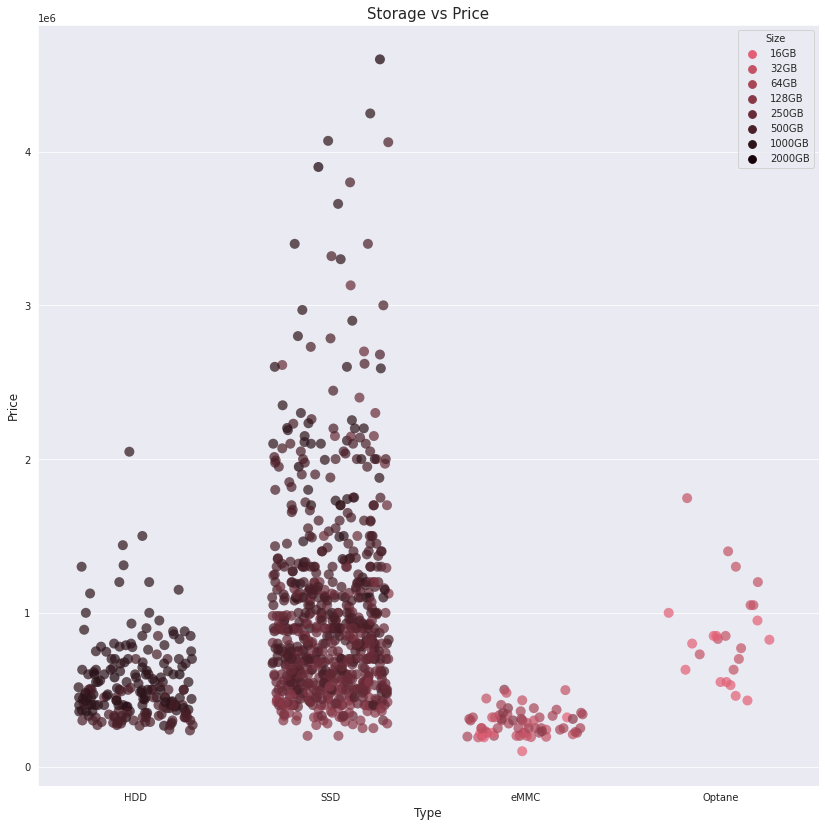

In [20]:
fig, ax = plt.subplots(figsize=(14, 14))
orders = ["16GB", "32GB", "64GB", "128GB", "250GB", "500GB", "1000GB", "2000GB"]
color_list = ["#e25f75", "#c45366", "#a74657", "#883948", "#682c38", "#491f28", "#2d131a", "#160009"]
sns.stripplot(data=df, x="storage_type", y="price", hue="storage_size", alpha=0.7, linewidth=0, ax=ax, size=10, jitter=0.3, palette=color_list, hue_order=orders)
ax.set_xlabel("Type", fontsize=12)
ax.set_ylabel("Price", fontsize=12)
ax.set_title("Storage vs Price", fontsize=15)
plt.legend(title="Size")
plt.show()

Evidently, **there is a relation between the `storage_type` and `price`**.

### RAM

Create the following new columns: 
* `ram_mhz`: the frecuency on mega-hertz.
* `ram_gb`: ram size in GB.

In [21]:
def get_ram_mhz(string):
    find = re.findall(r"[0-9]* MHz", string)[0]
    value = re.findall(r"[0-9]*", find)[0]
    return value
def get_ram_gb(string):
    find = re.findall(r"[0-9]* GB", string)[0]
    value = (re.findall(r"[0-9]*", find)[0])
    return value
df["ram_mhz"] = df["ram"].apply(lambda x: get_ram_mhz(x))
df["ram_gb"] = df["ram"].apply(lambda x: get_ram_gb(x))

Plot Ram vs Price 

Note that there are rams with 0 Mhz.

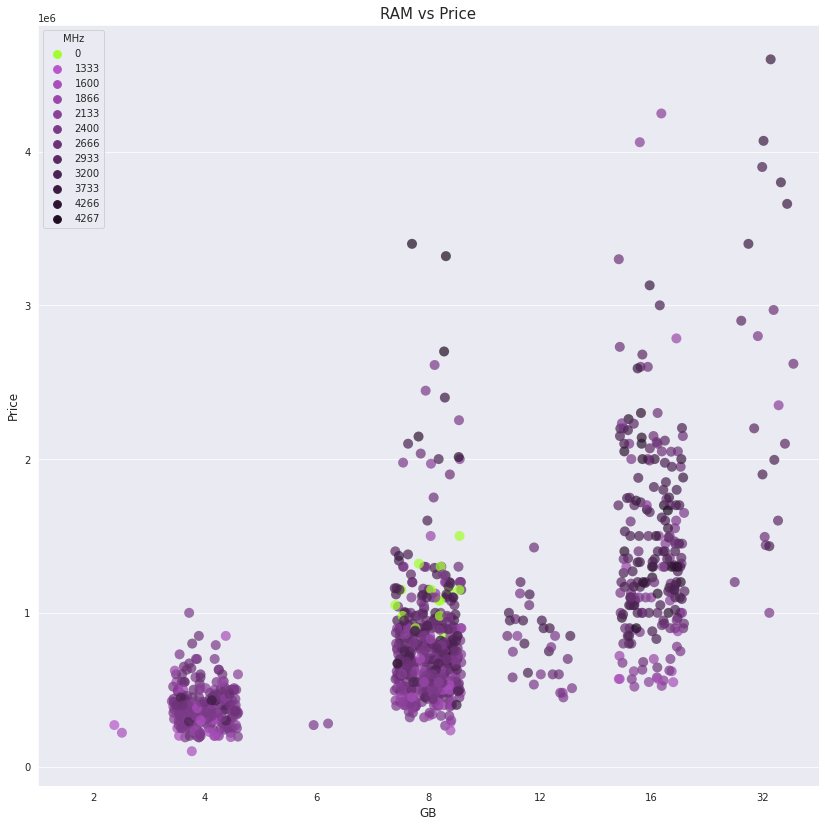

In [22]:
fig, ax = plt.subplots(figsize=(14, 14))
hues = sorted(df["ram_mhz"].unique())
color_list = ["#A1FF29", "#b757cb", "#a84fba", "#9948a9", "#8a4198", "#7b3a88", "#6b3275", "#5b2a63", "#4b2352", "#3c1b41", "#2e1431", "#200d22", "#160016"]
x_order = ["2", "4", "6", "8", "12", "16", "32"]
sns.stripplot(data=df, x="ram_gb", y="price", hue="ram_mhz", alpha=0.7, linewidth=0, ax=ax, size=10, jitter=0.3, palette=color_list, hue_order=hues, order=x_order)
ax.set_xlabel("GB", fontsize=12)
ax.set_ylabel("Price", fontsize=12)
ax.set_title("RAM vs Price", fontsize=15)
plt.legend(title="MHz")
plt.show()

**The more `ram_gb` the more `price`**. But no so clear for the `ram_mhz`

### Video Cards

Create the following new columns: 
* `video_card_brand`: the brand of the integrated card.
* `dedicated_card_brand`: the brand of the dedicated card.
* `dedicated_card_rating`: rate of each card gathered from the [notebook check web](https://www.notebookcheck.net/Mobile-Graphics-Cards-Benchmark-List.844.0.html).
* `dedicated_card_gb`: dedicated card available size in GB.

In [23]:
card_brands = ["Intel", "AMD", "NVIDIA", "Apple", "ARM", "Imagination"]
def get_card_brand(string):
    for brand in card_brands:
        if brand in string:
            return brand
dcard_brands = ["NVIDIA", "AMD"]
def get_dedicated_card_brand(string):
    for brand in dcard_brands:
        if brand in string:
            return brand
def get_card_gb(string):
    try:
        find = re.findall(r"[0-9]* GB", string)[0]
        value = int(re.findall(r"[0-9]*", find)[0])
        return value
    except:
        return 0

In [24]:
df["video_card_brand"] = df["video_card"].apply(lambda x: get_card_brand(x))
df["dedicated_video_card"].fillna(value="NA", inplace=True)
df["dedicated_card_brand"] = df["dedicated_video_card"].apply(lambda x: get_dedicated_card_brand(x))
df["dedicated_card_rating"] = 0
for idx, item in enumerate(df["dedicated_video_card"]):
    if "NVIDIA" in item:
        if "Quadro T500" in item:
            df.at[idx, "dedicated_card_rating"] = 270
        elif "Quadro T1000 Max-Q" in item:
            df.at[idx, "dedicated_card_rating"] = 267
        elif "Quadro T1000" in item:
            df.at[idx, "dedicated_card_rating"] = 268
        elif "Quadro RTX 3000 Max-Q" in item:
            df.at[idx, "dedicated_card_rating"] = 334
        elif "Quadro RTX 3000" in item:
            df.at[idx, "dedicated_card_rating"] = 338
        elif "Quadro P620" in item:
            df.at[idx, "dedicated_card_rating"] = 179
        elif "Quadro P520" in item:
            df.at[idx, "dedicated_card_rating"] = 142
        elif "Quadro P2000" in item:
            df.at[idx, "dedicated_card_rating"] = 246
        elif "Quadro M2200" in item:
            df.at[idx, "dedicated_card_rating"] = 207
        elif "Quadro M1200" in item:
            df.at[idx, "dedicated_card_rating"] = 180
        elif "RTX 3080" in item:
            df.at[idx, "dedicated_card_rating"] = 387
        elif "RTX 3070" in item:
            df.at[idx, "dedicated_card_rating"] = 379
        elif "RTX 3060" in item:
            df.at[idx, "dedicated_card_rating"] = 362
        elif "RTX 3050 Ti" in item:
            df.at[idx, "dedicated_card_rating"] = 321
        elif "RTX 3050" in item:
            df.at[idx, "dedicated_card_rating"] = 309
        elif "RTX 2080 Super Max-Q" in item:
            df.at[idx, "dedicated_card_rating"] = 359
        elif "RTX 2070 Super Max-Q" in item:
            df.at[idx, "dedicated_card_rating"] = 345
        elif "RTX 2070 Max-Q" in item:
            df.at[idx, "dedicated_card_rating"] = 342
        elif "RTX 2070" in item:
            df.at[idx, "dedicated_card_rating"] = 355
        elif "RTX 2060 Max-Q" in item:
            df.at[idx, "dedicated_card_rating"] = 330
        elif "RTX 2060" in item:
            df.at[idx, "dedicated_card_rating"] = 337
        elif "MX450" in item:
            df.at[idx, "dedicated_card_rating"] = 242
        elif "MX350" in item:
            df.at[idx, "dedicated_card_rating"] = 186
        elif "MX330" in item:
            df.at[idx, "dedicated_card_rating"] = 168
        elif "MX250" in item:
            df.at[idx, "dedicated_card_rating"] = 169
        elif "MX230" in item:
            df.at[idx, "dedicated_card_rating"] = 82
        elif "MX150" in item:
            df.at[idx, "dedicated_card_rating"] = 167
        elif "MX130" in item:
            df.at[idx, "dedicated_card_rating"] = 57
        elif "MX110" in item:
            df.at[idx, "dedicated_card_rating"] = 12
        elif "GTX 1660 Ti Max-Q" in item:
            df.at[idx, "dedicated_card_rating"] = 316
        elif "GTX 1660 Ti" in item:
            df.at[idx, "dedicated_card_rating"] = 322
        elif "GTX 1650 Ti Max-Q" in item:
            df.at[idx, "dedicated_card_rating"] = 278
        elif "GTX 1650 Ti" in item:
            df.at[idx, "dedicated_card_rating"] = 295
        elif "GTX 1650 Max-Q" in item:
            df.at[idx, "dedicated_card_rating"] = 270
        elif "GTX 1650" in item:
            df.at[idx, "dedicated_card_rating"] = 282
        elif "GTX 1050" in item:
            df.at[idx, "dedicated_card_rating"] = 227
        elif "940MX" in item:
            df.at[idx, "dedicated_card_rating"] = 56
    elif "AMD" in item:
        if "Pro 5500M" in item:
            df.at[idx, "dedicated_card_rating"] = 293
        elif "Pro 5300M" in item:
            df.at[idx, "dedicated_card_rating"] = 286
        elif "RX 5600M" in item:
            df.at[idx, "dedicated_card_rating"] = 324
        elif "RX 540" in item:
            df.at[idx, "dedicated_card_rating"] = 158
        elif "RX 640" in item:
            df.at[idx, "dedicated_card_rating"] = 176
        elif "530" in item:
            df.at[idx, "dedicated_card_rating"] = 18
        elif "535" in item:
            df.at[idx, "dedicated_card_rating"] = 18
df["dedicated_card_gb"] = df["dedicated_video_card"].apply(lambda x: get_card_gb(x))

Plot Integrated Card Brand vs Price.

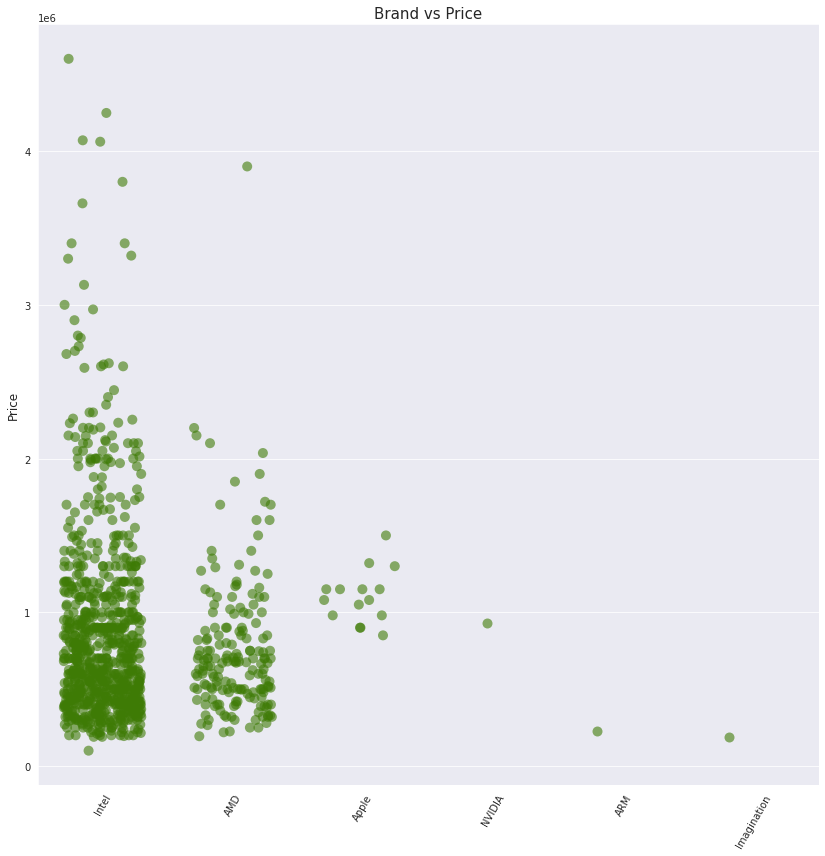

In [25]:
fig, ax = plt.subplots(figsize=(14, 14))
sns.stripplot(data=df, x="video_card_brand", y="price", alpha=0.6, linewidth=0, ax=ax, size=10, dodge=True, jitter=0.3, color="#3e7b05")
ax.set_xlabel("", fontsize=12)
ax.set_ylabel("Price", fontsize=12)
ax.set_title("Brand vs Price", fontsize=15)
plt.xticks(rotation=60)
plt.show()

Plot Dedicated Card vs Price

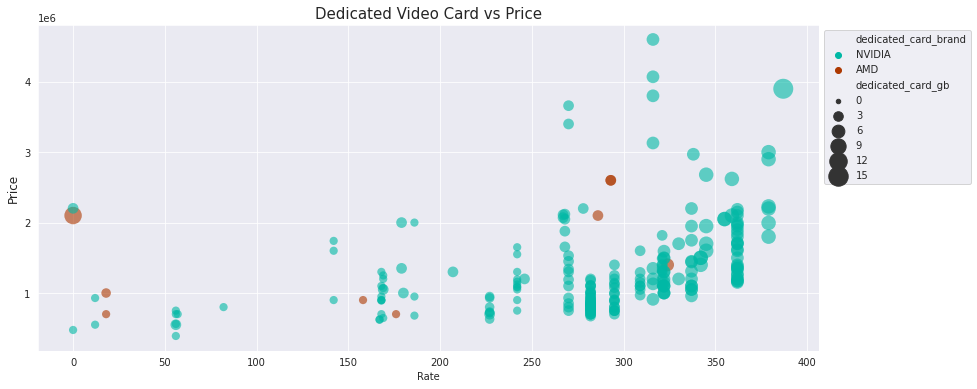

In [26]:
fig, ax = plt.subplots(figsize=(14, 6))
orders = ["NVIDIA", "AMD"]
color_list = ["#00B8A5", "#AD3800"]
sns.scatterplot(data=df, x="dedicated_card_rating", y="price", size="dedicated_card_gb", hue="dedicated_card_brand", alpha=0.6, 
                linewidth=0, ax=ax, sizes=(20, 400), hue_order=orders, palette=color_list)
ax.set_xlabel("Rate")
ax.set_ylabel("Price", fontsize=12)
ax.set_title("Dedicated Video Card vs Price", fontsize=15)
plt.legend(bbox_to_anchor=(1, 1), loc=0)
plt.show()

We have a **relation between the `dedicated_card_gb` and `price`**. It is not clear enough if `dedicated_card_rating` affects something.

### Statistics

Define the $X$ and $y$ variables to compute the statistics.

In [27]:
def get_screen_pixels(string):
    values = string.split("x")
    acc = 1
    for value in values:
        acc *= int(value)
    return acc

In [28]:
# Brand
X = pd.get_dummies(df["notebook_brand"], prefix="nb")
# Screen
X["screen_resolution"] = df["screen_resolution"].apply(lambda x: get_screen_pixels(x))
X["screen_in"] = df["screen_in"].apply(lambda x: int(x[4:6]))
_X = pd.get_dummies(df["screen_touch"], prefix="touch_screen")
X = pd.concat([_X, X], axis=1)
X["screen_hz"] = df["screen_hz"].apply(lambda x: int(x.split(" ")[0]))
# Processor
_X = pd.get_dummies(df["processor_brand"], prefix="pr")
X = pd.concat([_X, X], axis=1)
X["processor_cores"] = df["processor_cores"].apply(lambda x: int(x))
X["processor_mhz"] = df["processor_mhz"].apply(lambda x: int(x))
# Storage
_X = pd.get_dummies(df["storage_type"], prefix="st")
X = pd.concat([_X, X], axis=1)
X["storage_size"] = df["storage_size"].apply(lambda x: int(x.split("GB")[0]))
# RAM
X["ram_mhz"] = df["ram_mhz"].apply(lambda x: int(x))
X["ram_gb"] = df["ram_gb"].apply(lambda x: int(x))
# Video Cards
_X = pd.get_dummies(df["video_card_brand"], prefix="vc")
X = pd.concat([_X, X], axis=1)
X["dedicated_card_rating"] = df["dedicated_card_rating"]
X["dedicated_card_gb"] = df["dedicated_card_gb"]
_X = pd.get_dummies(df["dedicated_card_brand"], prefix="dc")
X = pd.concat([_X, X], axis=1)
# Price
y = df["price"].copy()

In [29]:
import statsmodels.api as sm
X_sm = sm.add_constant(X)
linear_model = sm.OLS(y, X_sm.astype(float))
results = linear_model.fit()
print(results.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.717
Model:                            OLS   Adj. R-squared:                  0.706
Method:                 Least Squares   F-statistic:                     60.84
Date:                Wed, 20 Oct 2021   Prob (F-statistic):          1.50e-232
Time:                        00:04:50   Log-Likelihood:                -14100.
No. Observations:                1000   AIC:                         2.828e+04
Df Residuals:                     959   BIC:                         2.848e+04
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -1.998e+

The report suggest:


*   **Adj. $R^2$:** $\sim 70\%$ of the variance is explained by the model.
*   **Prob ($F$-statistic):** We can reject the null hypothesis for the model.
*   **$p$-value:** variables with more than $5\%$ cannot be rejected.
*   **Omnibus:** $0\%$ of chance that the residuals are normally distributed.
*   **Durbin-Watson:** Almost ideal homoscedasticity.
*   **Condition Number:** Strong multicollinearity.



Compute the Variance Inflation Factor to check the inflated $\%$ of variance.

In [30]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
feat_cols = ["dc_NVIDIA", "st_HDD", "touch_screen_no", "nb_Apple", "nb_BMAX",
             "nb_Gigabyte", "nb_Huawei", "nb_Microsoft", "screen_resolution", 
             "processor_cores", "storage_size", "ram_mhz", "ram_gb", 
             "dedicated_card_gb"]
features = "+".join(feat_cols)
dm_data = pd.concat([X, y], axis=1)
y_dm, X_dm = dmatrices("price ~" + features, data=dm_data, return_type="dataframe")
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X_dm.values, i) for i in range(X_dm.shape[1])]
vif["variable"] = X_dm.columns
print(vif)

          VIF           variable
0   39.910004          Intercept
1    4.633654          dc_NVIDIA
2    2.871915             st_HDD
3    1.341925    touch_screen_no
4    1.495111           nb_Apple
5    1.017299            nb_BMAX
6    1.147143        nb_Gigabyte
7    1.118113          nb_Huawei
8    1.380558       nb_Microsoft
9    2.156982  screen_resolution
10   1.824756    processor_cores
11   2.807731       storage_size
12   1.404123            ram_mhz
13   2.191617             ram_gb
14   5.582483  dedicated_card_gb


For example. The variance of the `dc_NVIDIA` column is $463\%$ higher than what one would expect if there were no multicollinearity. And so on.

To get a moderate correlation, drop the variables having 5 $VIF$ or more.

In [31]:
X = X[feat_cols].copy()
X.drop(columns="dedicated_card_gb", inplace=True)

### Outlier Detection

Detect Outliers. There are many algorithms to detect outliers. Here is one of the simplest. Plot the residuals and discrimnate visually.

In [32]:
X_sm = sm.add_constant(X)
linear_model = sm.OLS(y, X_sm.astype(float))
results = linear_model.fit()
y_pred = results.predict(X_sm.astype(float))
residuals = y_pred - y
up_outliers = sorted(residuals)[-2:len(residuals)]
down_outliers = sorted(residuals)[0:10]
outliers = up_outliers + down_outliers
out_idxs = [True if item in outliers else False for idx, item in enumerate(residuals)]
in_idxs = [False if item in outliers else True for idx, item in enumerate(residuals)]

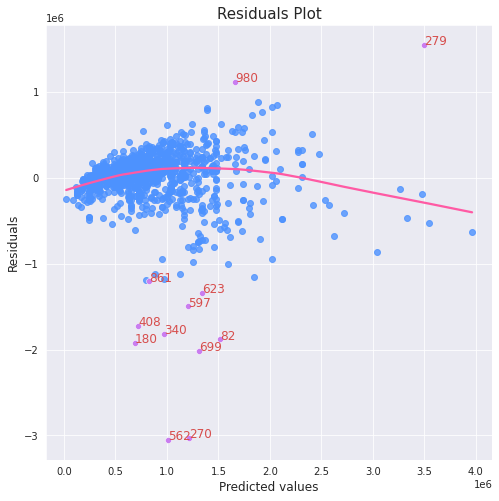

In [33]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.regplot(x=y_pred[in_idxs], y=residuals[in_idxs], ax=ax, color="#4D92FF", lowess=True, line_kws={"color": "#FF5AA4"})
sns.scatterplot(x=y_pred[out_idxs], y=residuals[out_idxs], color="#C97DF0", ax=ax)
for idx, item in enumerate(out_idxs):
    if item:
        plt.text(y_pred[idx], residuals[idx], f"{idx}", color="#D74D4C", size="large")
ax.set_xlabel("Predicted values", fontsize=12)
ax.set_ylabel("Residuals", fontsize=12)
ax.set_title("Residuals Plot", fontsize=15)
plt.show()

Also, **the "curved" pattern strongly implies that the model is non linear**. Which is what we were seeing all along.

Again, check the statistics with the resulting rows and columns.

In [34]:
X = X[in_idxs]
y = y[in_idxs]
X_sm = sm.add_constant(X)
linear_model = sm.OLS(y, X_sm.astype(float))
results = linear_model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     273.1
Date:                Wed, 20 Oct 2021   Prob (F-statistic):          8.15e-314
Time:                        00:04:50   Log-Likelihood:                -13724.
No. Observations:                 988   AIC:                         2.748e+04
Df Residuals:                     974   BIC:                         2.755e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -2.309e+05   5.16e+0

In [35]:
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

### Correlation

Check the linear correlation between features.

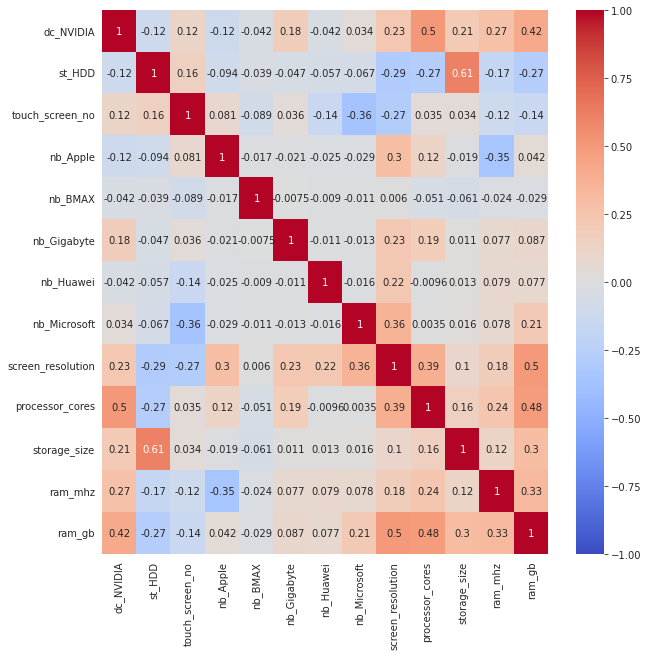

In [36]:
corr_matrix = X.corr()
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, center=0, ax=ax)
plt.show()

It seems to be a good selection of features.

In [37]:
# Optional for hyperparameter tunning
#from google.colab import drive
#drive.mount("/drive", force_remount=True)
#X.to_csv("/drive/My Drive/data-science/solotodo-notebooks-analysis/X.csv")
#y.to_csv("/drive/My Drive/data-science/solotodo-notebooks-analysis/y.csv")

## Machine Learning

The data is going to be fitted into two models Ridge Regression and Random Forest Regressor. One would want to know the predictive power of each variable. And thus consolidate the analysis carried out previously.

First define the cross-validation scorer function.

In [38]:
import sklearn
print(f"sklearn version: {sklearn.__version__}")

sklearn version: 0.22.2.post1


In [39]:
from sklearn.base import clone
from sklearn.model_selection import KFold
def mean_absolute_error(y, y_pred):
    acc = 0
    for idx in range(len(y_pred)):
        error = abs(y[idx]-y_pred[idx])
        acc += error
    acc = acc / len(y_pred)
    return acc
def get_scores(model, X=X, y=y, k=10):
    kf = KFold(n_splits=k)
    errors = []
    for train_idx, test_idx in kf.split(X):
        model_ = clone(model)
        model_.fit(X[train_idx], y[train_idx])
        y_pred = model_.predict(X[test_idx])
        err = mean_absolute_error(y[test_idx], y_pred)
        errors.append(err)
    return round(np.mean(errors), 2)

### Ridge Regression

Fit an euclidean hyperplane with a $\lambda\sum\beta_j^2$ regularization term. Where the $\beta_j$'s are the coefficients and $\lambda$ is a fixed positive.

Note: In order to get a faithful representation of the coefficients, one may scale the data to get mean $0$ and deviation $1$. and then normalize the data to lie inside $[0,1]$.

In [40]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
scaler_pipeline = make_pipeline(StandardScaler(), MinMaxScaler())
X_scaled = scaler_pipeline.fit_transform(X)

In [41]:
from sklearn.linear_model import Ridge
params = {'alpha': 3.357007933856045, 'fit_intercept': False, 
          'tol': 0.411850258814384, 'random_state': 555}
ridge = Ridge(**params)
print(f"Ridge Regression cv error: {get_scores(ridge, X=X_scaled, y=y.values)}")

Ridge Regression cv error: 185456.07


Plot the Feature Importances.

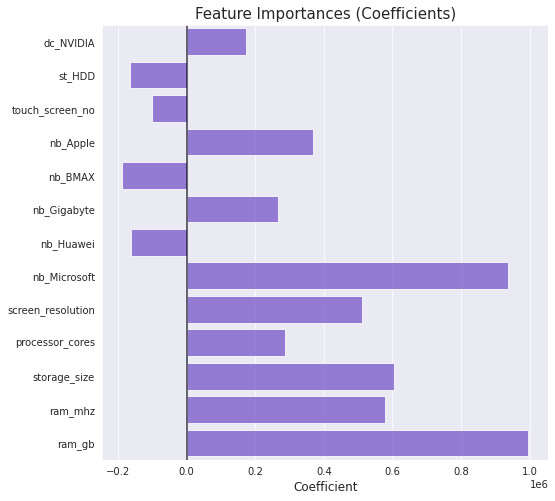

In [42]:
coeffs = ridge.fit(X_scaled, y).coef_
fig, ax = plt.subplots(figsize=(8, 8))
sns.barplot(x=coeffs, y=X.columns, color="#754EDE", alpha=0.8)
ax.set_title("Feature Importances (Coefficients)", fontsize=15)
ax.set_xlabel("Coefficient", fontsize=12)
plt.axvline(x=0, color="#0B0717", alpha=0.8)
plt.show()

In the barplot one can see how much each feature increases (or decreases) the final price. For example, **`nb_Microsoft` has the potential to increase up to $1,100,000$ the final price**.

### Random Forest Regressor

Fit $100$ decisions trees to ramdonly selected samples of the dataset.

In [43]:
from sklearn.ensemble import RandomForestRegressor
params = {'n_estimators': 508, 'criterion': 'mae', 
          'max_depth': 65, 'min_samples_split': 0.024371138348970756, 
          'min_samples_leaf': 0.010076361444197107, 'min_weight_fraction_leaf': 0.009321734735842187, 
          'max_features': 8, 'min_impurity_decrease': 0.9324005001492703, 
          'ccp_alpha': 0.8910237262960391, 'random_state': 555}
rfreg = RandomForestRegressor(**params)
print(f"Random Forest Regressor cv error: {get_scores(rfreg, X=X.values, y=y.values)}")

Random Forest Regressor cv error: 190082.78


Plot the Feature Importances.

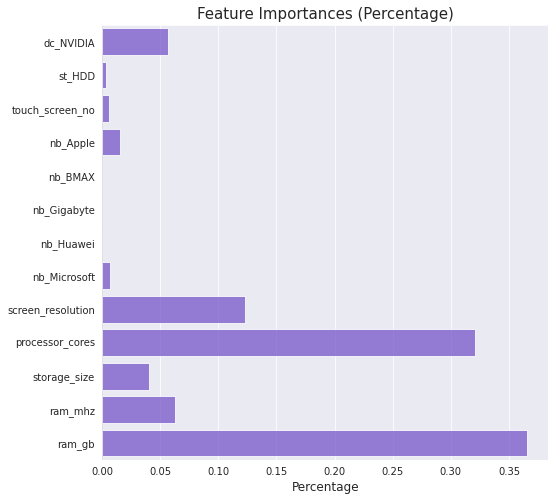

In [44]:
coeffs = rfreg.fit(X, y).feature_importances_
fig, ax = plt.subplots(figsize=(8, 8))
sns.barplot(x=coeffs, y=X.columns, color="#754EDE", alpha=0.8)
ax.set_title("Feature Importances (Percentage)", fontsize=15)
ax.set_xlabel("Percentage", fontsize=12)
plt.axvline(x=0, color="#0B0717", alpha=0.8)
plt.show()

Here, it is measured how many times (in $\%$) a feature appears inside nodes of all decision trees.

For example, the `nb_Microsoft` column has a higher coefficient but a lower percentage. That means that, despite affecting a lot, only a few cases were reported.

### Regression Validation

Now, a prediction must be made in the set that we leave aside, to validate our analysis.

First create the function that extracts the features described above.

In [45]:
def get_data(df):
    X = pd.DataFrame(index=df.index)
    X["dc_NVIDIA"] = 0
    for idx, item in zip(df.index, df["dedicated_video_card"]):
        if "NVIDIA" in str(item):
            X.at[idx, "dc_NVIDIA"] = 1
    X["st_HDD"] = 0
    for idx, item in zip(df.index, df["storage"]):
        if "HDD" in str(item):
            X.at[idx, "st_HDD"] = 1
    X["touch_screen_no"] = 0
    for idx, item in zip(df.index, df["screen"]):
        if not any(label in item for label in ["táctil", "tactil"]):
            X.at[idx, "touch_screen_no"] = 1
    X["nb_Apple"] = 0
    for idx, item in zip(df.index, df["name"]):
        if "Apple" in str(item):
            X.at[idx, "nb_Apple"] = 1
    X["nb_BMAX"] = 0
    for idx, item in zip(df.index, df["name"]):
        if "BMAX" in str(item):
            X.at[idx, "nb_BMAX"] = 1
    X["nb_Gigabyte"] = 0
    for idx, item in zip(df.index, df["name"]):
        if "Gigabyte" in str(item):
            X.at[idx, "nb_Gigabyte"] = 1
    X["nb_Huawei"] = 0
    for idx, item in zip(df.index, df["name"]):
        if "Huawei" in str(item):
            X.at[idx, "nb_Huawei"] = 1
    X["nb_Microsoft"] = 0
    for idx, item in zip(df.index, df["name"]):
        if "Microsoft" in str(item):
            X.at[idx, "nb_Microsoft"] = 1
    X["screen_resolution"] = df["screen"].apply(lambda x: re.findall(r"[0-9]*x[0-9]*", x)[0]).apply(lambda x: get_screen_pixels(x))    
    X["processor_cores"] = df["processor"].apply(lambda x: int(re.findall(r"[0-9]*[0-9]", re.findall(r"[0-9]* núcleos", x)[0])[0]))
    X["storage_size"] = 0
    for idx, item in zip(df.index, df["storage"]):
        if "16GB" in str(item):
            X.at[idx, "storage_size"] = 16
        if "32GB" in str(item):
            X.at[idx, "storage_size"] = 32
        if "64GB" in str(item):
            X.at[idx, "storage_size"] = 64
        if "128GB" in str(item):
            X.at[idx, "storage_size"] = 128
        if "250GB" in str(item):
            X.at[idx, "storage_size"] = 250
        if "240GB" in str(item):
            X.at[idx, "storage_size"] = 240
        if "256GB" in str(item):
            X.at[idx, "storage_size"] = 256
        if "480GB" in str(item):
            X.at[idx, "storage_size"] = 480
        if "512GB" in str(item):
            X.at[idx, "storage_size"] = 512
        if "500GB" in str(item):
            X.at[idx, "storage_size"] = 500
        if "1TB" in str(item):
            X.at[idx, "storage_size"] = 1000
        if "2TB" in str(item):
            X.at[idx, "storage_size"] = 2000
    X["ram_mhz"] = df["ram"].apply(lambda x: int(get_ram_mhz(x)))
    X["ram_gb"] = df["ram"].apply(lambda x: int(get_ram_gb(x)))
    y = df["price"].copy()
    return X, y

Get the validation data.

In [46]:
X_val, y_val = get_data(validation_df)

Predict using the Ridge Regression Model.

In [47]:
X_val_scaled = scaler_pipeline.transform(X_val)
y_pred = ridge.predict(X_val_scaled)
err = round(mean_absolute_error(y_val.values, y_pred), 2)
print(f"Ridge Regression Validation error: {err}")

Ridge Regression Validation error: 211320.22


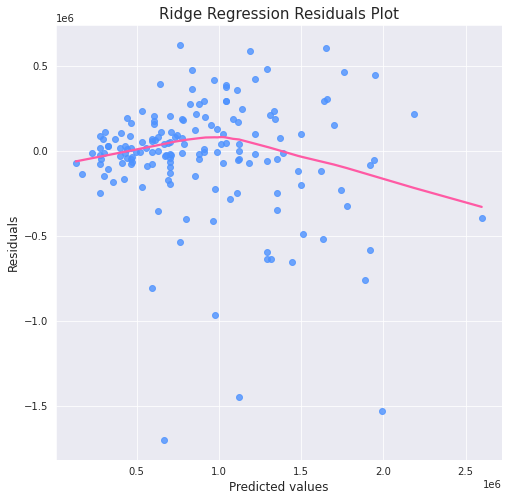

In [48]:
residuals = y_pred - y_val
fig, ax = plt.subplots(figsize=(8, 8))
sns.regplot(x=y_pred, y=residuals, ax=ax, color="#4D92FF", lowess=True, line_kws={"color": "#FF5AA4"})
ax.set_xlabel("Predicted values", fontsize=12)
ax.set_ylabel("Residuals", fontsize=12)
ax.set_title("Ridge Regression Residuals Plot", fontsize=15)
plt.show()

Predict using the Random Forest Regressor

In [49]:
y_pred = rfreg.predict(X_val.values)
err = round(mean_absolute_error(y_val.values, y_pred), 2)
print(f"Random Forest Regressor Validation: {err}")

Random Forest Regressor Validation: 229601.58


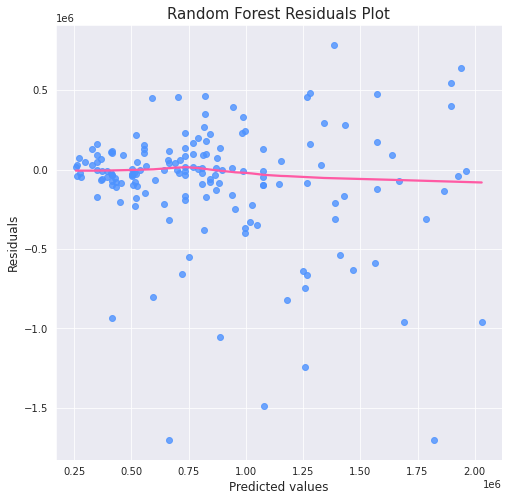

In [50]:
residuals = y_pred - y_val
fig, ax = plt.subplots(figsize=(8, 8))
sns.regplot(x=y_pred, y=residuals, ax=ax, color="#4D92FF", lowess=True, line_kws={"color": "#FF5AA4"})
ax.set_xlabel("Predicted values", fontsize=12)
ax.set_ylabel("Residuals", fontsize=12)
ax.set_title("Random Forest Residuals Plot", fontsize=15)
plt.show()

### Neural Network

In [51]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop

In [52]:
reg_in = Input(shape=(X.shape[1], ))
dense1 = Dense(128, activation="relu")(reg_in)
drop1 = Dropout(0.1)(dense1)
dense2 = Dense(64, activation="relu")(drop1)
drop2 = Dropout(0.1)(dense2)
dense3 = Dense(32, activation="relu")(drop2)
drop3 = Dropout(0.1)(dense3)
dense4 = Dense(8, activation="relu")(drop3)
reg_out = Dense(1, activation="relu")(dense4)
nnreg = Model(inputs=reg_in, outputs=reg_out)
opt = RMSprop(learning_rate=0.01, momentum=0.8)
nnreg.compile(optimizer=opt, loss="mean_absolute_error", metrics=["mean_absolute_error"])
nnreg.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 13)]              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1792      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0     

In [53]:
%%time
history = nnreg.fit(X_scaled, y.values, validation_data=(X_val_scaled, y_val.values), epochs=1000, batch_size=32, verbose=0)

CPU times: user 1min 15s, sys: 4.45 s, total: 1min 20s
Wall time: 1min 22s


No handles with labels found to put in legend.


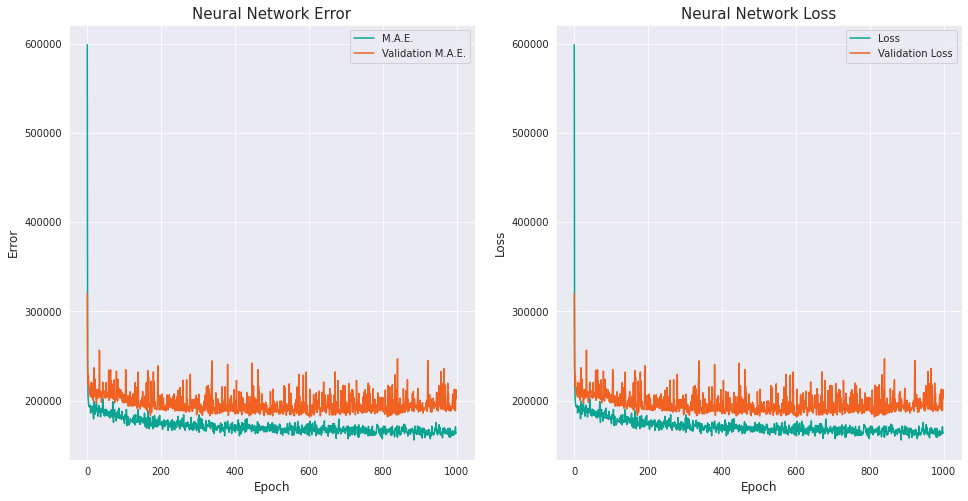

In [54]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 8))
sns.lineplot(data=history.history["mean_absolute_error"], label="M.A.E.", color="#0BA391", linewidth=1.5, ax=axes[0])
sns.lineplot(data=history.history["val_mean_absolute_error"], label="Validation M.A.E.", color="#F06122", linewidth=1.5, ax=axes[0])
axes[0].set_title("Neural Network Error", fontsize=15)
axes[0].set_xlabel("Epoch", fontsize=12)
axes[0].set_ylabel("Error", fontsize=12)
plt.legend(loc="upper right")
sns.lineplot(data=history.history["loss"], label="Loss", color="#0BA391", linewidth=1.5, ax=axes[1])
sns.lineplot(data=history.history["val_loss"], label="Validation Loss", color="#F06122", linewidth=1.5, ax=axes[1])
axes[1].set_title("Neural Network Loss", fontsize=15)
axes[1].set_xlabel("Epoch", fontsize=12)
axes[1].set_ylabel("Loss", fontsize=12)
plt.legend(loc="upper right")
plt.show()

In [55]:
y_pred = nnreg.predict(X_val_scaled).ravel()
err = round(mean_absolute_error(y_val.values, y_pred), 2)
print(f"Neural Network Regressor error: {err}")

Neural Network Regressor error: 202341.88


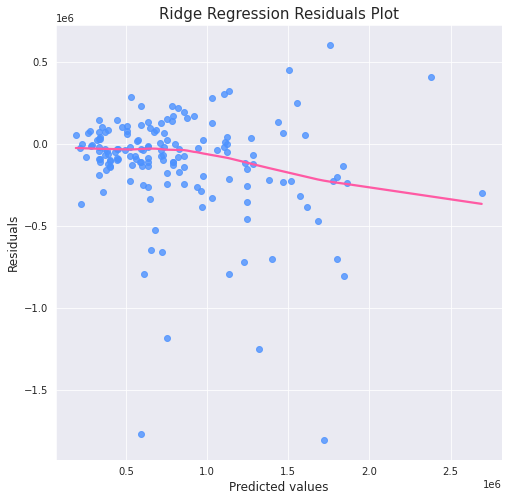

In [56]:
y_pred = nnreg.predict(X_val_scaled).ravel()
residuals = y_pred - y_val
fig, ax = plt.subplots(figsize=(8, 8))
sns.regplot(x=y_pred, y=residuals, ax=ax, color="#4D92FF", lowess=True, line_kws={"color": "#FF5AA4"})
ax.set_xlabel("Predicted values", fontsize=12)
ax.set_ylabel("Residuals", fontsize=12)
ax.set_title("Ridge Regression Residuals Plot", fontsize=15)
plt.show()

## Conclusion

We obtained a list of notebook components that influence the most when prices have to be set. And one can trust them, taking into account an mean absolute error of $\sim200,000$.